In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime


import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import google.cloud.bigquery as bq
client = bq.Client.from_service_account_json("marius_arlauskas.json")

In [2]:
df = pd.read_csv('real.csv', index_col=0)

In [3]:
df.isna().sum()/len(df)

visit_started_at     0.000
user_id              0.986
order_id             0.986
transactionId        0.971
clientId             0.000
sourceMedium         0.000
campaign             0.000
orderCouponCode      0.986
sessionId            0.000
time_dif             0.971
upsell_price_value   0.971
sub_price_value      0.971
tax_value            0.971
transactionRevenue   0.971
subchannel           0.000
channel              0.004
dtype: float64

In [4]:
new_df = pd.DataFrame()
new_df['cookie'] = df['clientId']
new_df['conversion'] = df['transactionRevenue'].notna()*1
new_df['conversion_value'] = df['transactionRevenue'].fillna(0)
new_df['time'] = df['visit_started_at']
new_df['channel'] = df['channel']
new_df['sourceMedium'] = df['sourceMedium']
new_df['subchannel'] = df['subchannel']

df = new_df

In [5]:
df.dropna(inplace=True)

In [6]:
from collections import defaultdict

df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [7]:
df_paths = df.groupby('cookie')[['channel', 'time']].aggregate(
    lambda x: x.tolist()).reset_index()


In [8]:
df_paths['conversion'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion'][df_paths['cookie']].values
df_paths['conversion_value'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion_value'][df_paths['cookie']].values

In [9]:
from datetime import datetime
def get_journey_len(x):
    first = x[0]
    last = x[-1]
    first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
    last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
    return (last - first).total_seconds()


In [10]:
def time_in_between(x):
    rez = [np.nan]
    for i in range(len(x) - 1):
        first = x[i]
        last = x[i+1]
        first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
        last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
        rez.append((last - first).total_seconds())
    return np.array(rez)

In [11]:
df_paths['journey_full_time']  = df_paths['time'].apply(get_journey_len)

In [12]:
df_paths['in_between_sessions'] = df_paths['time'].apply(time_in_between)

In [13]:
df_paths['journey_len'] = df_paths['channel'].apply(len)

In [14]:
df_paths['avg_time_in_between'] = df_paths['in_between_sessions'].apply(np.nanmean)

In [15]:
df_paths[df_paths['conversion']==1]['journey_len'].describe()

count   75257.000
mean        2.126
std         2.795
min         1.000
25%         1.000
50%         1.000
75%         2.000
max       241.000
Name: journey_len, dtype: float64

In [16]:
df_paths['n_unique_chn'] = df_paths['channel'].apply(set)
df_paths['n_unique_chn'] = df_paths['n_unique_chn'].apply(len)

In [17]:
df_paths

,cookie,channel,time,conversion,conversion_value,journey_full_time,in_between_sessions,journey_len,avg_time_in_between,n_unique_chn
0,40.166,[brand],[2022-08-30 15:59:00+00:00],0,0.000,0.000,[nan],1,NaN,1
1,1585.166,[organic],[2022-08-26 12:19:15+00:00],0,0.000,0.000,[nan],1,NaN,1
2,1701.166,[organic],[2022-08-04 08:08:52+00:00],0,0.000,0.000,[nan],1,NaN,1
3,2560.166,[affiliates_vps],[2022-08-18 08:06:31+00:00],0,0.000,0.000,[nan],1,NaN,1
4,2749.166,[ppc],[2022-08-17 05:33:07+00:00],0,0.000,0.000,[nan],1,NaN,1
...,...,...,...,...,...,...,...,...,...,...
3007267,2147481070.166,[brand],[2022-08-05 23:01:50+00:00],0,0.000,0.000,[nan],1,NaN,1
3007268,2147481892.166,"[organic, organic, organic, organic]","[2022-08-14 12:06:46+00:00, 2022-08-14 12:11:4...",0,0.000,2928254.000,"[nan, 297.0, 2736678.0, 191279.0]",4,976084.667,1
3007269,2147482217.166,[organic],[2022-08-28 05:34:50+00:00],1,59.760,0.000,[nan],1,NaN,1
3007270,2147482730.166,"[other, other, other, other]","[2022-08-31 17:12:27+00:00, 2022-09-01 20:10:5...",0,0.000,402984.000,"[nan, 97112.0, 294240.0, 11632.0]",4,134328.000,1


In [18]:
unique_channels = df['channel'].unique()

In [19]:
#def counter(x, chn):
#    return x.count(chn)
#
#for chn in unique_channels:
#    df_paths[chn] = df_paths['channel'].apply(counter, chn=chn)

In [21]:
def time_from(x):
    rez = []
    for i in range(len(x)):
        first = x[i]
        last = x[-1]
        first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
        last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
        rez.append((last - first).total_seconds())
    return np.array(rez) / 3600

In [22]:
df_paths['decay'] = df_paths['time'].apply(time_from)

In [23]:
df_paths

,cookie,channel,time,conversion,conversion_value,journey_full_time,in_between_sessions,journey_len,avg_time_in_between,n_unique_chn,decay
0,40.166,[brand],[2022-08-30 15:59:00+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
1,1585.166,[organic],[2022-08-26 12:19:15+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
2,1701.166,[organic],[2022-08-04 08:08:52+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
3,2560.166,[affiliates_vps],[2022-08-18 08:06:31+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
4,2749.166,[ppc],[2022-08-17 05:33:07+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
...,...,...,...,...,...,...,...,...,...,...,...
3007267,2147481070.166,[brand],[2022-08-05 23:01:50+00:00],0,0.000,0.000,[nan],1,NaN,1,[0.0]
3007268,2147481892.166,"[organic, organic, organic, organic]","[2022-08-14 12:06:46+00:00, 2022-08-14 12:11:4...",0,0.000,2928254.000,"[nan, 297.0, 2736678.0, 191279.0]",4,976084.667,1,"[813.4038888888889, 813.3213888888889, 53.1330..."
3007269,2147482217.166,[organic],[2022-08-28 05:34:50+00:00],1,59.760,0.000,[nan],1,NaN,1,[0.0]
3007270,2147482730.166,"[other, other, other, other]","[2022-08-31 17:12:27+00:00, 2022-09-01 20:10:5...",0,0.000,402984.000,"[nan, 97112.0, 294240.0, 11632.0]",4,134328.000,1,"[111.94, 84.96444444444444, 3.2311111111111113..."


In [24]:
prep_df = df_paths[['cookie', 'channel']]

In [25]:
prep_df['conversion'] = df_paths['conversion']

In [26]:
prep_df['conversion_value'] = df_paths['conversion_value']

In [27]:
prep_df['time_till_conv_agg'] = df_paths['decay']

In [35]:
prep_df['cookie'] = prep_df['cookie'].astype(str)

In [37]:
prep_df

,journey_id,channels_agg,converted_agg,conversion_value,time_till_conv_agg
0,40.1661875141,brand,False,0.000,0.0
1,1585.1661516338,organic,False,0.000,0.0
2,1701.1659600532,organic,False,0.000,0.0
3,2560.1660809988,affiliates_vps,False,0.000,0.0
4,2749.1660714377,ppc,False,0.000,0.0
...,...,...,...,...,...
3007267,2147481070.165974,brand,False,0.000,0.0
3007268,2147481892.166048,organic > organic > organic > organic,False,0.000,813.4038888888889 > 813.3213888888889 > 53.133...
3007269,2147482217.1661663,organic,True,59.760,0.0
3007270,2147482730.1661963,other > other > other > other,False,0.000,111.94 > 84.96444444444444 > 3.231111111111111...


In [30]:
def joiner(x):
    return ' > '.join(str(v) for v in x)
prep_df['channel'] = prep_df['channel'].apply(joiner)
prep_df['time_till_conv_agg'] = prep_df['time_till_conv_agg'].apply(list).apply(joiner)

In [31]:
prep_df['conversion'] = prep_df['conversion'].astype(bool)


In [32]:
prep_df.columns = ['journey_id', 'channels_agg', 'converted_agg', 'conversion_value',
       'time_till_conv_agg']

In [45]:
from marketing_attribution_models import MAM

In [46]:
attributions = MAM(prep_df, time_till_conv_colname='time_till_conv_agg', conversion_value='conversion_value', channels_colname='channels_agg', journey_with_conv_colname='converted_agg')

In [48]:
results = attributions.attribution_all_models()

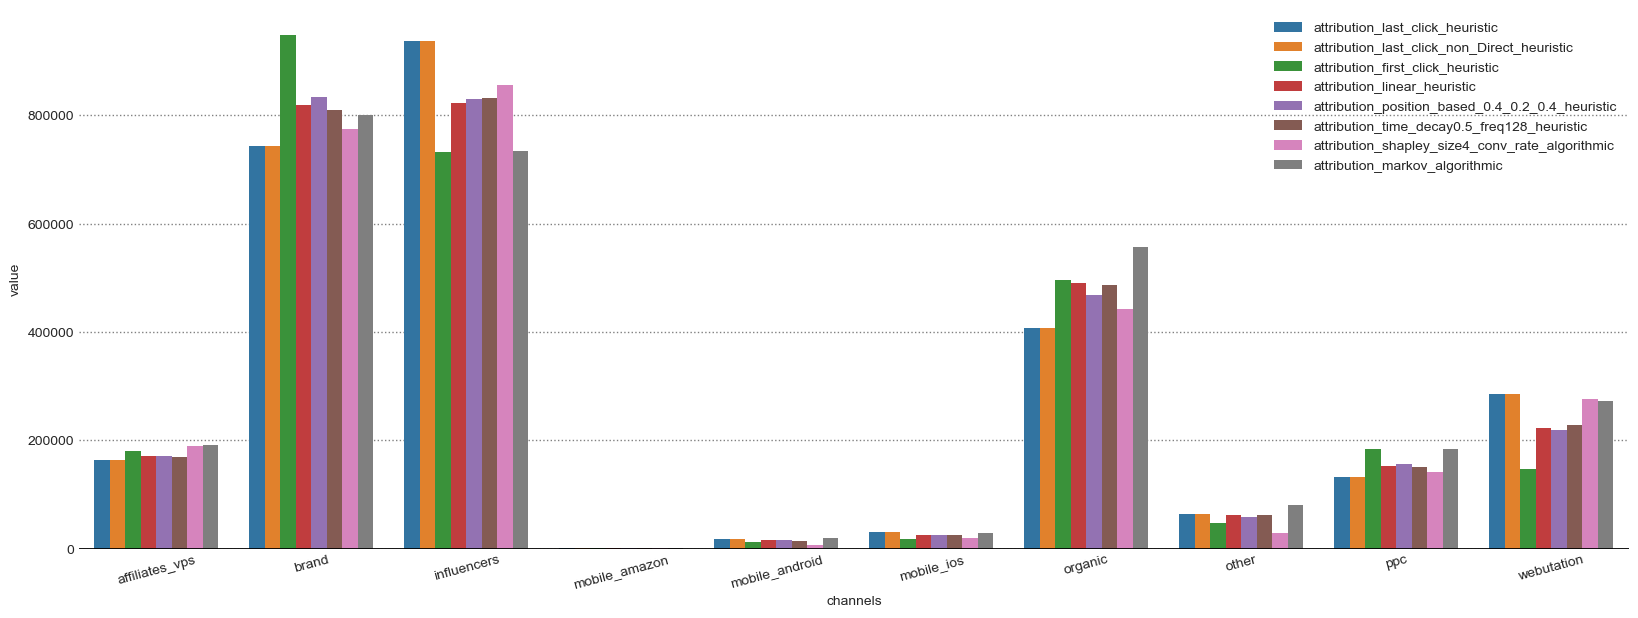

In [62]:
fig = attributions.plot()
plt.legend(loc = "upper right")


In [59]:
results.to_csv('attributions.csv')

In [9]:
def start(x):
    x.insert(0, 'Start')
    return x
df_paths['path'] = df_paths['path'].apply(start)

In [10]:
def conv(x):
    x.append('Conversion')
    return x

def non_conv(x):
    x.append('Null')
    return x

In [34]:
df_paths['conversion'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion'][df_paths['cookie']].values
df_paths['conversion_value'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion_value'][df_paths['cookie']].values

In [12]:
df_paths = df_paths[['cookie', 'path', 'conversion']]

In [13]:
df_paths[df_paths['conversion'] == 0]['path'] = df_paths[df_paths['conversion'] == 0]['path'].apply(non_conv)

In [14]:
df_paths[df_paths['conversion'] == 1]['path'] = df_paths[df_paths['conversion'] == 1]['path'].apply(conv)

In [ ]:
# Upsampling, seems like not really worth it
#df_paths['conversion_value'] = (df_paths['conversion_value'] / 10).apply(round)
#df_paths['conversion_value'][df_paths['conversion_value'] == 0] = 1
#df_paths = df_paths.loc[df_paths.index.repeat(df_paths['conversion_value'])]

In [16]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [17]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

In [18]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [19]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [20]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [21]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, 100)
attributions

In [24]:
rdf = df.drop_duplicates(subset=['cookie'], keep='last')

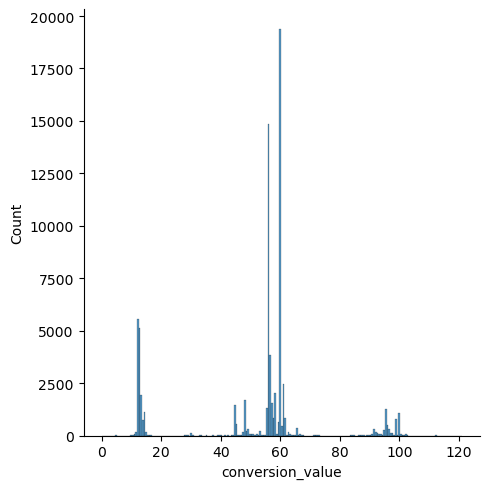

In [25]:
import seaborn as sns
rdf = rdf[rdf['conversion_value'] != 0]
sns.displot(rdf['conversion_value'])

<AxesSubplot:xlabel='conversion_value', ylabel='Count'>

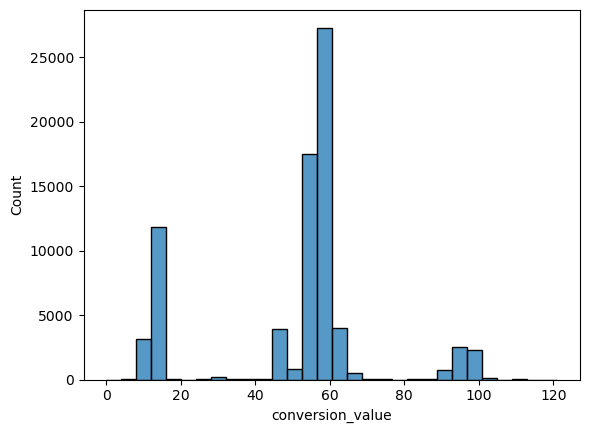

In [49]:
sns.histplot(rdf['conversion_value'], bins=30)

In [27]:
attributions = markov_chain_allocations(removal_effects_dict, 5340112)
attributions

{'influencers': 1029014.1498786495,
 'webutation': 319383.5625096834,
 'mobile_android': 35781.62174334855,
 'other': 132315.6980633989,
 'affiliates_vps': 223029.55172438003,
 'mobile_ios': 48852.99555003848,
 'affiliates_nonvps': 1390742.0572385634,
 'brand': 1195833.7510660696,
 'ppc': 235868.91150476682,
 'mobile_amazon': 2019.0247498498425,
 'organic': 727270.6759712524}

In [116]:
'>'.join(str(v) for v in prep_df['time_till_conv_agg'][3007270])

'111.94>84.96444444444444>3.2311111111111113>0.0'